<a href="https://colab.research.google.com/github/lstr-calms/AI-Agents/blob/main/EmbeddingGemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Login into Hugging Face Hub
from huggingface_hub import login
login()

In [2]:
#Install library for fuzzy matching
!pip install fuzzywuzzy python-Levenshtein -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.7 MB/s eta 0:00:00


In [28]:
import pandas as pd
from fuzzywuzzy import fuzz
import time
import psutil
import os
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import process
import torch
import numpy as np

In [4]:
parcel_data = {
    'Parcel_ID': [f'WV-95{i:02d}' for i in range(1, 51)],
    'Contents': [
        'Dell XPS 15 Laptop', 'Textbook Collection', 'Handmade Ceramic Coffee Mug', 'Nike Athletic T-shirt', 'iPhone 15 Pro', 'Crystal Wine Glass Set', 'Premium Dog Food', 'Framed Oil Painting', 'Luxury Makeup Kit', 'Legal Documents',
        'Canon 70-200mm Camera Lens', 'Herman Miller Chair Assembly', 'Belgian Dark Chocolates', 'DeWalt Cordless Drill', 'LEGO Building Blocks', 'Adidas Running Shoes', 'Multivitamin Supplements', 'PlayStation 5 Console', 'Garden Tool Set', 'Vintage Wall Clock',
        'Keurig Coffee Maker', 'Samsung 1TB SSD', 'Professional Skateboard', 'Silk Designer Scarf', 'Monopoly Board Game', 'Whey Protein Powder', 'LED Car Headlight', 'Photo Frame Collection', 'Sony Wireless Headphones', 'Premium Yoga Mat',
        'Campbell Soup Variety Pack', 'Modern Desk Lamp', 'Genuine Leather Wallet', 'Adjustable Curtain Rod', 'Baby Formula Powder', 'Fishing Rod Combo', 'Mechanical Keyboard', 'Chanel Perfume', 'Egyptian Cotton Sheets', 'Rice Cooker Appliance',
        'Professional Binoculars', '4-Person Camping Tent', 'Custom Birthday Cake', 'Electric Toothbrush Set', 'Classic Vinyl Records', 'Adjustable Dumbbells', 'Cashmere Sweater', 'US Passport', 'Garden Seed Packets', 'Designer Sunglasses'
    ],
    'Notes': [
        'Fragile electronics, contains lithium battery, handle with extreme care.', 'Heavy textbooks, media mail shipping, 12kg total weight.', 'Handmade ceramic, extremely fragile, extra padding required.', 'Apparel, size Medium, lightweight cotton material.', 'High-value electronics, signature required, original packaging.',
        'Crystal glassware, extremely fragile, do not stack, handle with care.', 'Premium pet food, 15kg bag, standard shipping.', 'Framed artwork, protect corners, fragile glass front.', 'Liquid cosmetics, seal integrity checked, flammable contents.', 'Critical documents, priority mailer, do not bend or fold.',
        'High-value camera equipment, requires signature, insurance recommended.', 'Office furniture parts, bulky item, box 1 of 2 shipments.', 'Perishable chocolates, keep cool, temperature sensitive.', 'Power tool with battery, contains lithium, handle with care.', 'Children\'s toys, age 3+, standard packaging.',
        'Athletic apparel, size 10 Men\'s, moisture-wicking fabric.', 'Supplement bottle, safety seal intact, check expiration date.', 'Gaming console, electronics, original retail packaging.', 'Garden tools, sharp edges, set of 5 pieces.', 'Vintage clock, fragile glass face, handle with care.',
        'Small kitchen appliance, handle with care, electrical components.', 'Computer storage device, static-sensitive electronics.', 'Sports equipment, oversized package, long and narrow.', 'Luxury apparel, lightweight silk, special handling.', 'Board game, standard box, contains small plastic pieces.',
        'Protein supplement, large plastic container, 2kg weight.', 'Automotive part, fragile LED bulb, handle with care.', 'Picture frames, set of 5, glass fronts, fragile.', 'Electronics, retail packaging, wireless connectivity.', 'Exercise equipment, rolled mat, in protective sleeve.',
        'Grocery items, case of 12 cans, standard shipping.', 'Desk lamp, contains fragile lightbulb, handle with care.', 'Leather goods, small high-value item, in gift box.', 'Home improvement, long metal rod, do not bend.', 'Baby formula, powder form, check expiration date.',
        'Fishing equipment, long and fragile, sports gear.', 'Computer peripheral, mechanical switches, electronics.', 'Perfume bottle, glass container, flammable liquid.', 'Bedding, Queen size sheets, home goods category.', 'Kitchen appliance, electrical, in original box.',
        'Optical equipment, precision lenses, handle with care.', 'Outdoor camping gear, 5kg weight, weather resistant.', 'Custom cake, perishable, keep upright during transport.', 'Personal care item, electrical, battery operated.', 'Music media, vinyl records, do not expose to heat.',
        'Exercise equipment, heavy item, 20kg total weight.', 'Luxury apparel, size Large, 100% cashmere wool.', 'Critical travel document, signature required, high security.', 'Garden supplies, seed packets, keep dry storage.', 'Fashion accessory, designer sunglasses, in protective case.'
    ]
}
parcel_df = pd.DataFrame(parcel_data)

In [5]:
claim_data = {
    'Claim_ID': [f'CL-77{i:02d}' for i in range(1, 51)],
    'Corresponding_Parcel_ID': [f'WV-95{i:02d}' for i in range(1, 51)],
    'Claim_Text': [
        'The corner of my laptop is dented and the screen has a crack in the bottom right corner.', 'The box was left on my porch in the rain and all the books are completely soaked and ruined.', 'My ceramic mug arrived in pieces - the handle broke off and there are chips all over.',
        'I got the wrong size t-shirt, this is not what I ordered at all', 'The box for the smartphone was already open when it arrived.', 'I could hear rattling inside, the glassware set was completely shattered into tiny pieces',
        'The bag of pet food was ripped open and spilled all over inside the box', 'The artwork frame is broken on one side and the glass is cracked.', 'The makeup leaked everywhere, the cap must have been loose during shipping',
        'My documents are bent and creased because the mailer was folded in half.', 'The camera lens glass is scratched and has fingerprints all over it.', 'The main part of the office chair is missing, I only got the wheels and base',
        'The chocolate was all melted into one big blob and is completely ruined.', 'The power drill doesn\'t work at all, it won\'t turn on when I press the trigger', 'The box of toys was crushed and some of the smaller LEGO pieces fell out',
        'Wrong size shoes delivered - I ordered 10 but got size 8.', 'The safety seal on the vitamin bottle was broken and some pills spilled out', 'The video game console box was retaped, looks like it was opened and resealed',
        'One of the gardening tools is rusted and the handle is loose.', 'The glass on the wall clock is cracked and the hands don\'t move properly.', 'The coffee maker has a huge dent in the side and won\'t brew properly',
        'Hard drive not detected by my computer - it\'s completely dead on arrival.', 'The skateboard has a huge chip in the wood deck and the trucks are bent', 'The scarf has a pull in the fabric and the silk is frayed',
        'My board game is missing half of the pieces - no money, no houses, no hotels', 'Protein powder lid was open and powder spilled everywhere inside the box', 'This is the wrong headlight for my car model - it doesn\'t fit at all',
        'Two of the picture frames have shattered glass and the frames are dented', 'Wireless headphones only play sound in one ear, the other side is completely dead', 'Yoga mat has a permanent crease and won\'t lay flat anymore',
        'Several of the soup cans are badly dented and one is leaking', 'The lamp came with a broken lightbulb and the base is scratched', 'The leather on the wallet is scuffed and the stitching is coming apart',
        'Curtain rod arrived bent in the middle and won\'t hang straight', 'Can of baby formula was expired by 6 months when it arrived', 'The tip of the fishing rod is snapped off and the line guide is missing',
        'Some of the keys on the keyboard don\'t work - the spacebar and enter key are stuck', 'Perfume bottle leaked during shipping and the box is soaked', 'I ordered Queen bed sheets but I received Twin size instead',
        'The rice cooker is missing the power cord and the inner pot has scratches', 'One of the lenses on the binoculars is foggy inside and won\'t focus', 'The tent has a rip in the fabric near the zipper and won\'t stay closed',
        'Birthday cake was delivered on its side and is completely ruined - icing everywhere', 'The toothbrush package was already torn open and the brush head is missing', 'The vinyl record is warped and skips constantly when played',
        'Box for the dumbbells broke open during shipping, delivery guy had to tape it back together', 'Sweater has a hole in the sleeve and the cashmere is pilled', 'My passport never arrived - tracking says delivered but it\'s not here',
        'Packet of plant seeds was empty, there was a hole in the packaging', 'Sunglasses are the wrong color - I ordered black but got brown frames'
    ]
}
claims_df = pd.DataFrame(claim_data)

In [6]:
# Introduce typos, misspellings, and OCR-like errors to make the dataset more realistic
import random
import re

def introduce_typos(text, typo_probability=0.15):
    """
    Introduce various types of typos and OCR-like errors to text.

    Args:
        text: Input text to modify
        typo_probability: Probability of introducing an error per word

    Returns:
        Text with introduced errors
    """
    words = text.split()
    modified_words = []

    for word in words:
        if random.random() < typo_probability and len(word) > 2:
            # Skip very short words and common short words
            if word.lower() in {'a', 'an', 'the', 'is', 'at', 'to', 'in', 'on', 'it', 'be', 'as', 'by', 'or', 'of', 'my', 'me', 'we', 'he', 'so', 'up', 'if', 'go', 'no', 'us', 'am', 'do'}:
                modified_words.append(word)
                continue

            error_type = random.choice([
                'substitution', 'insertion', 'deletion', 'transposition',
                'case_error', 'punctuation_error', 'spacing_error'
            ])

            if error_type == 'substitution' and len(word) > 2:
                # Substitute a character
                pos = random.randint(1, len(word) - 2)  # Avoid first and last chars
                char = word[pos]
                if char.isalpha():
                    new_char = random.choice('abcdefghijklmnopqrstuvwxyz')
                    word = word[:pos] + new_char + word[pos+1:]

            elif error_type == 'insertion' and len(word) < 15:
                # Insert an extra character
                pos = random.randint(1, len(word))
                extra_char = random.choice('abcdefghijklmnopqrstuvwxyz')
                word = word[:pos] + extra_char + word[pos:]

            elif error_type == 'deletion' and len(word) > 3:
                # Delete a character
                pos = random.randint(1, len(word) - 2)
                word = word[:pos] + word[pos+1:]

            elif error_type == 'transposition' and len(word) > 3:
                # Swap adjacent characters
                pos = random.randint(0, len(word) - 2)
                word = word[:pos] + word[pos+1] + word[pos] + word[pos+2:]

            elif error_type == 'case_error':
                # Random case changes
                if word.isalpha():
                    word = ''.join(c.upper() if random.random() < 0.5 else c.lower() for c in word)

            elif error_type == 'punctuation_error':
                # Add or remove punctuation
                if random.random() < 0.5:
                    word += random.choice('.,!?;:')
                else:
                    word = re.sub(r'[.,!?;:]', '', word)

            elif error_type == 'spacing_error':
                # Add extra spaces or remove spaces
                if random.random() < 0.5:
                    word = word.replace(' ', '  ')  # Double space
                else:
                    word = word.replace(' ', '')  # Remove spaces

        modified_words.append(word)

    return ' '.join(modified_words)

def introduce_ocr_errors(text, error_probability=0.12):
    """
    Introduce OCR-specific errors that commonly occur during scanning.

    Args:
        text: Input text to modify
        error_probability: Probability of introducing an error per character

    Returns:
        Text with OCR-like errors
    """
    # Common OCR character substitutions
    ocr_substitutions = {
        '0': 'O', 'O': '0',  # Zero vs O
        '1': 'l', 'l': '1',  # One vs lowercase L
        '5': 'S', 'S': '5',  # Five vs S
        '8': 'B', 'B': '8',  # Eight vs B
        '6': 'G', 'G': '6',  # Six vs G
        'I': '1', '1': 'I',  # I vs 1
        'r': 'n', 'n': 'r',  # r vs n
        'm': 'rn', 'rn': 'm',  # m vs rn
        'cl': 'd', 'd': 'cl',  # cl vs d
        'u': 'n', 'n': 'u',  # u vs n
        'v': 'u', 'u': 'v',  # v vs u
        'w': 'vv', 'vv': 'w',  # w vs vv
        'c': 'e', 'e': 'c',  # c vs e
        'a': 'o', 'o': 'a',  # a vs o
        's': '5', '5': 's',  # s vs 5
        't': 'f', 'f': 't',  # t vs f
        'h': 'b', 'b': 'h',  # h vs b
        'p': 'q', 'q': 'p',  # p vs q
        'd': 'b', 'b': 'd',  # d vs b
    }

    result = ""
    i = 0
    while i < len(text):
        char = text[i]

        if random.random() < error_probability and char in ocr_substitutions:
            # Apply OCR substitution
            if random.random() < 0.7:  # 70% chance of substitution
                result += ocr_substitutions[char]
            else:  # 30% chance of character deletion
                pass  # Skip this character
        else:
            result += char

        i += 1

    return result

def introduce_spacing_errors(text, spacing_probability=0.08):
    """
    Introduce spacing errors common in OCR.

    Args:
        text: Input text to modify
        spacing_probability: Probability of introducing spacing errors

    Returns:
        Text with spacing errors
    """
    words = text.split()
    if len(words) < 2:
        return text

    modified_words = []
    for i, word in enumerate(words):
        modified_words.append(word)

        if random.random() < spacing_probability and i < len(words) - 1:
            # Introduce spacing error
            error_type = random.choice(['missing_space', 'extra_space', 'wrong_space'])

            if error_type == 'missing_space':
                # Merge with next word
                if i < len(words) - 1:
                    modified_words[-1] += words[i + 1]
                    words[i + 1] = ""  # Mark for removal
            elif error_type == 'extra_space':
                # Add extra space
                modified_words.append("")
            elif error_type == 'wrong_space':
                # Split word incorrectly
                if len(word) > 4:
                    split_pos = random.randint(2, len(word) - 2)
                    modified_words[-1] = word[:split_pos]
                    modified_words.append(word[split_pos:])

    # Remove empty strings and join
    return ' '.join([w for w in modified_words if w])

# Apply errors to parcel data
print("Introducing typos and OCR errors to parcel data...")

# Create modified parcel data with errors
modified_parcel_data = {
    'Parcel_ID': parcel_data['Parcel_ID'].copy(),
    'Contents': [],
    'Notes': []
}

for i in range(len(parcel_data['Contents'])):
    # Apply different error types with different probabilities
    contents = parcel_data['Contents'][i]
    notes = parcel_data['Notes'][i]

    # Apply typos to contents (lower probability for product names)
    modified_contents = introduce_typos(contents, typo_probability=0.08)
    modified_contents = introduce_ocr_errors(modified_contents, error_probability=0.06)
    modified_contents = introduce_spacing_errors(modified_contents, spacing_probability=0.05)

    # Apply more errors to notes (higher probability for descriptions)
    modified_notes = introduce_typos(notes, typo_probability=0.12)
    modified_notes = introduce_ocr_errors(modified_notes, error_probability=0.10)
    modified_notes = introduce_spacing_errors(modified_notes, spacing_probability=0.08)

    modified_parcel_data['Contents'].append(modified_contents)
    modified_parcel_data['Notes'].append(modified_notes)

# Apply errors to claim data
print("Introducing typos and OCR errors to claim data...")

modified_claim_data = {
    'Claim_ID': claim_data['Claim_ID'].copy(),
    'Corresponding_Parcel_ID': claim_data['Corresponding_Parcel_ID'].copy(),
    'Claim_Text': []
}

for i in range(len(claim_data['Claim_Text'])):
    claim_text = claim_data['Claim_Text'][i]

    # Apply various error types to claims
    modified_claim = introduce_typos(claim_text, typo_probability=0.15)
    modified_claim = introduce_ocr_errors(modified_claim, error_probability=0.12)
    modified_claim = introduce_spacing_errors(modified_claim, spacing_probability=0.10)

    modified_claim_data['Claim_Text'].append(modified_claim)

# Create new dataframes with modified data
parcel_df_modified = pd.DataFrame(modified_parcel_data)
claims_df_modified = pd.DataFrame(modified_claim_data)

print("✅ Modified datasets created with typos and OCR errors")
print(f"Original parcel count: {len(parcel_df)}")
print(f"Modified parcel count: {len(parcel_df_modified)}")
print(f"Original claim count: {len(claims_df)}")
print(f"Modified claim count: {len(claims_df_modified)}")

# Show some examples of the modifications
print("\n📝 EXAMPLES OF MODIFICATIONS:")
print("=" * 80)

print("\nPARCEL CONTENTS (Original vs Modified):")
for i in range(5):
    print(f"\n{i+1}. Original:  {parcel_data['Contents'][i]}")
    print(f"   Modified:  {modified_parcel_data['Contents'][i]}")

print("\nPARCEL NOTES (Original vs Modified):")
for i in range(3):
    print(f"\n{i+1}. Original:  {parcel_data['Notes'][i]}")
    print(f"   Modified:  {modified_parcel_data['Notes'][i]}")

print("\nCLAIM TEXTS (Original vs Modified):")
for i in range(5):
    print(f"\n{i+1}. Original:  {claim_data['Claim_Text'][i]}")
    print(f"   Modified:  {modified_claim_data['Claim_Text'][i]}")

# Update the main dataframes to use modified data
parcel_df = parcel_df_modified
claims_df = claims_df_modified

print(f"\n🔄 Updated main dataframes with modified data")
print("Ready to test matching algorithms with realistic OCR errors!")

Introducing typos and OCR errors to parcel data...
Introducing typos and OCR errors to claim data...
✅ Modified datasets created with typos and OCR errors
Original parcel count: 50
Modified parcel count: 50
Original claim count: 50
Modified claim count: 50

📝 EXAMPLES OF MODIFICATIONS:

PARCEL CONTENTS (Original vs Modified):

1. Original:  Dell XPS 15 Laptop
   Modified:  Del XPS 15 Laptop

2. Original:  Textbook Collection
   Modified:  Textbook COLLectioN

3. Original:  Handmade Ceramic Coffee Mug
   Modified:  Handmde Ceramic Coffee Mug

4. Original:  Nike Athletic T-shirt
   Modified:  Nike Athleti T-shirt

5. Original:  iPhone 15 Pro
   Modified:  iPonc 15 Pro

PARCEL NOTES (Original vs Modified):

1. Original:  Fragile electronics, contains lithium battery, handle with extreme care.
   Modified:  Fragile electronics, contains lithium battery, handle with extneme eare.

2. Original:  Heavy textbooks, media mail shipping, 12kg total weight.
   Modified:  Heavy textbooks, media mai

In [7]:
# Verify dataset sizes
print(f"Parcel dataset size: {len(parcel_df)} entries")
print(f"Claim dataset size: {len(claims_df)} entries")
print(f"Parcel IDs: {parcel_df['Parcel_ID'].tolist()}")
print(f"Claim IDs: {claims_df['Claim_ID'].tolist()}")
print(f"Corresponding Parcel IDs: {claims_df['Corresponding_Parcel_ID'].tolist()}")

# Verify all entries are unique
print(f"\nUnique Parcel IDs: {len(parcel_df['Parcel_ID'].unique())}")
print(f"Unique Claim IDs: {len(claims_df['Claim_ID'].unique())}")
print(f"Unique Corresponding Parcel IDs: {len(claims_df['Corresponding_Parcel_ID'].unique())}")

# Check if all corresponding parcel IDs exist in parcel dataset
missing_parcels = set(claims_df['Corresponding_Parcel_ID']) - set(parcel_df['Parcel_ID'])
if missing_parcels:
    print(f"❌ Missing parcels in parcel dataset: {missing_parcels}")
else:
    print("✅ All corresponding parcel IDs exist in parcel dataset")


Parcel dataset size: 50 entries
Claim dataset size: 50 entries
Parcel IDs: ['WV-9501', 'WV-9502', 'WV-9503', 'WV-9504', 'WV-9505', 'WV-9506', 'WV-9507', 'WV-9508', 'WV-9509', 'WV-9510', 'WV-9511', 'WV-9512', 'WV-9513', 'WV-9514', 'WV-9515', 'WV-9516', 'WV-9517', 'WV-9518', 'WV-9519', 'WV-9520', 'WV-9521', 'WV-9522', 'WV-9523', 'WV-9524', 'WV-9525', 'WV-9526', 'WV-9527', 'WV-9528', 'WV-9529', 'WV-9530', 'WV-9531', 'WV-9532', 'WV-9533', 'WV-9534', 'WV-9535', 'WV-9536', 'WV-9537', 'WV-9538', 'WV-9539', 'WV-9540', 'WV-9541', 'WV-9542', 'WV-9543', 'WV-9544', 'WV-9545', 'WV-9546', 'WV-9547', 'WV-9548', 'WV-9549', 'WV-9550']
Claim IDs: ['CL-7701', 'CL-7702', 'CL-7703', 'CL-7704', 'CL-7705', 'CL-7706', 'CL-7707', 'CL-7708', 'CL-7709', 'CL-7710', 'CL-7711', 'CL-7712', 'CL-7713', 'CL-7714', 'CL-7715', 'CL-7716', 'CL-7717', 'CL-7718', 'CL-7719', 'CL-7720', 'CL-7721', 'CL-7722', 'CL-7723', 'CL-7724', 'CL-7725', 'CL-7726', 'CL-7727', 'CL-7728', 'CL-7729', 'CL-7730', 'CL-7731', 'CL-7732', 'CL-7733',

In [8]:
# Keyword matching
def keyword_search_matcher(claim_text, parcels_dataframe):
    """
    Finds the best parcel match based on shared keywords with improved accuracy.
    Returns the Parcel_ID of the best match.
    """
    import re

    # Enhanced text preprocessing
    def preprocess_text(text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        # Split into words and remove common stop words
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'its', 'our', 'their'}
        words = [word for word in text.split() if word not in stop_words and len(word) > 2]
        return set(words)

    claim_keywords = preprocess_text(claim_text)
    best_match_id = None
    best_score = 0

    for index, row in parcels_dataframe.iterrows():
        parcel_keywords = preprocess_text(row['Search_Text'])

        # Calculate intersection and union for Jaccard similarity
        intersection = len(claim_keywords.intersection(parcel_keywords))
        union = len(claim_keywords.union(parcel_keywords))

        # Use Jaccard similarity with a bonus for exact matches
        if union > 0:
            jaccard_score = intersection / union
            # Bonus for high intersection count
            intersection_bonus = min(intersection * 0.1, 0.5)
            total_score = jaccard_score + intersection_bonus
        else:
            total_score = 0

        if total_score > best_score:
            best_score = total_score
            best_match_id = row['Parcel_ID']

    return best_match_id

# Create a combined text column for searching in parcel_df
parcel_df['Search_Text'] = parcel_df['Contents'] + ' ' + parcel_df['Notes']

# Apply the keyword matcher to every claim
claims_df['Keyword_Match'] = claims_df['Claim_Text'].apply(lambda x: keyword_search_matcher(x, parcel_df))

print("✅ Keyword search complete.")
display(claims_df[['Claim_Text', 'Corresponding_Parcel_ID', 'Keyword_Match']].head(10))

✅ Keyword search complete.


,Claim_Text,Corresponding_Parcel_ID,Keyword_Match
0,The crner of my laptap is dente aneb fhe scecu...,WV-9501,None
1,The dox was left on my porch in he rain and al...,WV-9502,WV-9525
2,My cenamic mug arrived in pieccs - the handle ...,WV-9503,WV-9503
3,"1 got the wrong sze t-shirt, fhis i5 not vvhat...",WV-9504,WV-9510
4,The box for the smartphone was already open wh...,WV-9505,WV-9540
5,"I cold bar rattling inside, thc glasswane se w...",WV-9506,WV-9519
6,The bag of pct foadwpa5 ripped open and spille...,WV-9507,WV-9540
7,Tbe artwork frame is br oken on anc sibe and t...,WV-9508,None
8,"The makeup leaked everyvvhere, the eap must ha...",WV-9509,WV-9507
9,My documents are bentg ad erea5ed because te m...,WV-9510,None


In [9]:
# Fuzzy Matching
def fuzzy_search_matcher(claim_text, parcels_dataframe):
    """
    Enhanced fuzzy matching using multiple fuzzy algorithms for better accuracy.
    Combines token_set_ratio, partial_ratio, and token_sort_ratio for robust matching.
    Returns the Parcel_ID of the best match.
    """
    scores = []
    for index, row in parcels_dataframe.iterrows():
        # Use multiple fuzzy matching algorithms
        token_set_score = fuzz.token_set_ratio(claim_text, row['Search_Text'])
        partial_score = fuzz.partial_ratio(claim_text, row['Search_Text'])
        token_sort_score = fuzz.token_sort_ratio(claim_text, row['Search_Text'])

        # Weighted combination of different fuzzy scores
        # token_set_ratio gets highest weight as it's most robust for different word orders
        combined_score = (token_set_score * 0.5) + (partial_score * 0.3) + (token_sort_score * 0.2)

        scores.append((combined_score, row['Parcel_ID']))

    # Return the Parcel_ID of the highest score
    return max(scores, key=lambda item: item[0])[1]

# Apply the fuzzy matcher to every claim
claims_df['Fuzzy_Match'] = claims_df['Claim_Text'].apply(lambda x: fuzzy_search_matcher(x, parcel_df))

print("✅ Fuzzy search complete.")
claims_df[['Claim_Text', 'Corresponding_Parcel_ID', 'Fuzzy_Match']].head(10)

✅ Fuzzy search complete.


,Claim_Text,Corresponding_Parcel_ID,Fuzzy_Match
0,The crner of my laptap is dente aneb fhe scecu...,WV-9501,WV-9540
1,The dox was left on my porch in he rain and al...,WV-9502,WV-9525
2,My cenamic mug arrived in pieccs - the handle ...,WV-9503,WV-9521
3,"1 got the wrong sze t-shirt, fhis i5 not vvhat...",WV-9504,WV-9504
4,The box for the smartphone was already open wh...,WV-9505,WV-9514
5,"I cold bar rattling inside, thc glasswane se w...",WV-9506,WV-9519
6,The bag of pct foadwpa5 ripped open and spille...,WV-9507,WV-9525
7,Tbe artwork frame is br oken on anc sibe and t...,WV-9508,WV-9508
8,"The makeup leaked everyvvhere, the eap must ha...",WV-9509,WV-9503
9,My documents are bentg ad erea5ed because te m...,WV-9510,WV-9510


No charts were generated by quickchart


In [10]:
# Comprehensive evaluation and comparison of all matching methods
print("=" * 80)
print("MATCHING ALGORITHM EVALUATION")
print("=" * 80)

# Calculate accuracy for each method
def calculate_accuracy(predictions, actual):
    correct = sum(1 for pred, act in zip(predictions, actual) if pred == act)
    return (correct / len(predictions)) * 100

keyword_accuracy = calculate_accuracy(claims_df['Keyword_Match'], claims_df['Corresponding_Parcel_ID'])
fuzzy_accuracy = calculate_accuracy(claims_df['Fuzzy_Match'], claims_df['Corresponding_Parcel_ID'])

print(f"Keyword Matching Accuracy: {keyword_accuracy:.2f}%")
print(f"Fuzzy Matching Accuracy: {fuzzy_accuracy:.2f}%")

# Show detailed comparison
print("\n" + "=" * 80)
print("DETAILED COMPARISON (First 20 Claims)")
print("=" * 80)

comparison_df = claims_df[['Claim_Text', 'Corresponding_Parcel_ID', 'Keyword_Match', 'Fuzzy_Match']].head(20)
comparison_df['Keyword_Correct'] = comparison_df['Keyword_Match'] == comparison_df['Corresponding_Parcel_ID']
comparison_df['Fuzzy_Correct'] = comparison_df['Fuzzy_Match'] == comparison_df['Corresponding_Parcel_ID']

display(comparison_df)

# Show mismatches for analysis
print("\n" + "=" * 80)
print("MISMATCH ANALYSIS")
print("=" * 80)

mismatches = claims_df[claims_df['Keyword_Match'] != claims_df['Corresponding_Parcel_ID']]
print(f"Keyword Mismatches: {len(mismatches)} out of {len(claims_df)}")

mismatches = claims_df[claims_df['Fuzzy_Match'] != claims_df['Corresponding_Parcel_ID']]
print(f"Fuzzy Mismatches: {len(mismatches)} out of {len(claims_df)}")


MATCHING ALGORITHM EVALUATION
Keyword Matching Accuracy: 38.00%
Fuzzy Matching Accuracy: 46.00%

DETAILED COMPARISON (First 20 Claims)


,Claim_Text,Corresponding_Parcel_ID,Keyword_Match,Fuzzy_Match,Keyword_Correct,Fuzzy_Correct
0,The crner of my laptap is dente aneb fhe scecu...,WV-9501,None,WV-9540,False,False
1,The dox was left on my porch in he rain and al...,WV-9502,WV-9525,WV-9525,False,False
2,My cenamic mug arrived in pieccs - the handle ...,WV-9503,WV-9503,WV-9521,True,False
3,"1 got the wrong sze t-shirt, fhis i5 not vvhat...",WV-9504,WV-9510,WV-9504,False,True
4,The box for the smartphone was already open wh...,WV-9505,WV-9540,WV-9514,False,False
5,"I cold bar rattling inside, thc glasswane se w...",WV-9506,WV-9519,WV-9519,False,False
6,The bag of pct foadwpa5 ripped open and spille...,WV-9507,WV-9540,WV-9525,False,False
7,Tbe artwork frame is br oken on anc sibe and t...,WV-9508,None,WV-9508,False,True
8,"The makeup leaked everyvvhere, the eap must ha...",WV-9509,WV-9507,WV-9503,False,False
9,My documents are bentg ad erea5ed because te m...,WV-9510,None,WV-9510,False,True



MISMATCH ANALYSIS
Keyword Mismatches: 31 out of 50
Fuzzy Mismatches: 27 out of 50


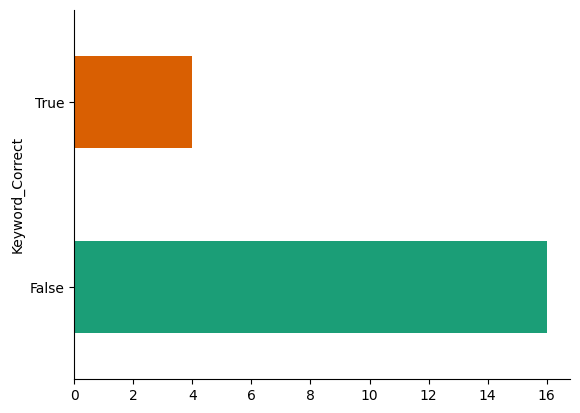

In [11]:
# @title Keyword_Correct

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Keyword_Correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

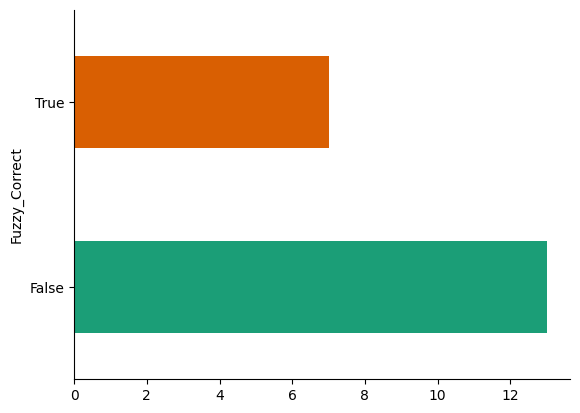

In [12]:
# @title Fuzzy_Correct

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Fuzzy_Correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
#Load Model
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/embeddinggemma-300M"
model = SentenceTransformer(model_id).to(device=device)

print(f"Device: {model.device}")
print(model)
print("Total number of parameters in the model:", sum([p.numel() for _, p in model.named_parameters()]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Device: cuda:0
SentenceTransformer(
  (0): Transformer({'max_seq_length': 2048, 'do_lower_case': False, 'architecture': 'Gemma3TextModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 3072, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (3): Dense({'in_features': 3072, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (4): Normalize()
)
Total number of parameters in the model: 307581696


In [29]:
# --- 1.1 Baseline: Fuzzy Search ---
def run_fuzzy_search(claims, parcels):
    print("--- 🧐 Baseline: Fuzzy Search Results ---")
    for claim in claims:
        match, score = process.extractOne(claim, parcels)
        print(f"Claim: '{claim}'\n  -> Best Match: '{match}' (Score: {score})\n")

# --- 1.2 Embedding Similarity ---
def run_embedding_search(model, claims, parcels):
    print("--- ✨ Embedding Search Results ---")
    # Generate embeddings for all parcels and claims
    parcel_embeddings = model.encode(parcels, convert_to_tensor=True)
    claim_embeddings = model.encode(claims, convert_to_tensor=True)

    # Calculate cosine similarity between each claim and all parcels
    cosine_scores = util.cos_sim(claim_embeddings, parcel_embeddings)

    # Find the best match for each claim
    for i, claim in enumerate(claims):
        best_match_index = torch.argmax(cosine_scores[i])
        best_score = cosine_scores[i][best_match_index].item()
        best_match_description = parcels[best_match_index]
        print(f"Claim: '{claim}'\n  -> Best Match: '{best_match_description}' (Score: {best_score:.4f})\n")

# --- 1.3 Run and Compare ---
# Load the Matryoshka-capable model
model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True)
print(f"Default embedding dimension: {model.get_sentence_embedding_dimension()}")

run_fuzzy_search(claims, parcels)
run_embedding_search(model, claims, parcels)

Default embedding dimension: 768


NameError: name 'claims' is not defined

**Determining Similarity**

In this section, we use embeddings to determine how semantically similar different sentences are. Here are examples with high, medium, and low similarity scores.














In [ ]:
# Sentences to encode
sentence_high = [
    "Dell XPS 15 Laptop",
    "The corner of my laptop is dented and the screen has a crack in the bottom right corner."
]
sentence_medium = [
    "iPhone 15 Pro",
    "The new Samsung smartwatch has a battery issue."
]
sentence_low = [
    "Textbook Collection",
    "One of the gardening tools is rusted and the handle is loose."
]

for sentence in [sentence_high, sentence_medium, sentence_low]:
  print("🙋‍♂️")
  print(sentence)
  embeddings = model.encode(sentence)
  similarities = model.similarity(embeddings[0], embeddings[1])
  print("`-> 🤖 score: ", similarities.numpy()[0][0])

🙋‍♂️
['Dell XPS 15 Laptop', 'The corner of my laptop is dented and the screen has a crack in the bottom right corner.']
`-> 🤖 score:  0.7166525
🙋‍♂️
['iPhone 15 Pro', 'The new Samsung smartwatch has a battery issue.']
`-> 🤖 score:  0.68334186
🙋‍♂️
['Textbook Collection', 'One of the gardening tools is rusted and the handle is loose.']
`-> 🤖 score:  0.6734024


In [ ]:
#EmbeddingGemma Classification
labels = ["Product", "Claim Description", "Notes"]

sentence = [
  "Dell XPS 15 Laptop",
  "The corner of my laptop is dented and the screen has a crack in the bottom right corner.",
]

# Calculate embeddings by calling model.encode()
label_embeddings = model.encode(labels, prompt_name="Classification")
embeddings = model.encode(sentence, prompt_name="Classification")

# Calculate the embedding similarities
similarities = model.similarity(embeddings, label_embeddings)
print(similarities)

idx = similarities.argmax(1)
print(idx)

for example in sentence:
  print("🙋‍♂️", example, "-> 🤖", labels[idx[sentence.index(example)]])

tensor([[0.6898, 0.6774, 0.6833],
        [0.5308, 0.6085, 0.5678]])
tensor([0, 1])
🙋‍♂️ Dell XPS 15 Laptop -> 🤖 Product
🙋‍♂️ The corner of my laptop is dented and the screen has a crack in the bottom right corner. -> 🤖 Claim Description


In [ ]:
# Import required libraries for embedding matching
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the EmbeddingGemma model
print("Loading EmbeddingGemma-300m model...")
model = SentenceTransformer("google/embeddinggemma-300m")
print(" Model loaded successfully!")

def embedding_search_matcher(claim_text, parcels_dataframe, model):
    """
    Finds the best parcel match using semantic similarity with EmbeddingGemma.
    Uses cosine similarity between claim and parcel embeddings.
    Returns the Parcel_ID of the best match.
    """
    # Generate embedding for the claim
    claim_embedding = model.encode([claim_text])

    best_match_id = None
    best_similarity = -1

    for index, row in parcels_dataframe.iterrows():
        # Generate embedding for the parcel description
        parcel_embedding = model.encode([row['Search_Text']])

        # Calculate cosine similarity
        similarity = cosine_similarity(claim_embedding, parcel_embedding)[0][0]

        if similarity > best_similarity:
            best_similarity = similarity
            best_match_id = row['Parcel_ID']

    return best_match_id

# Apply the embedding matcher to every claim
print("Applying embedding-based matching...")
claims_df['Embedding_Match'] = claims_df['Claim_Text'].apply(
    lambda x: embedding_search_matcher(x, parcel_df, model)
)

print("✅ Embedding search complete.")

Loading EmbeddingGemma-300m model...


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

✅ Model loaded successfully!
Applying embedding-based matching...
✅ Embedding search complete.


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load model if not already loaded
try:
	_ = model  # noqa: F821
except NameError:
	print("Loading EmbeddingGemma-300m model...")
	model = SentenceTransformer("google/embeddinggemma-300m")
	print("✅ Model loaded successfully!")

# Precompute and cache parcel embeddings (normalized)
if "_parcel_embeddings" not in globals():
	print("Encoding parcel texts (this runs once)...")
	parcel_texts = parcel_df["Search_Text"].tolist()
	_parcel_embeddings = model.encode(
		parcel_texts,
		batch_size=32,
		show_progress_bar=True,
		convert_to_numpy=True,
		normalize_embeddings=True,
	)
	print("✅ Parcel embeddings cached.")

# Batch-encode all claims and compute best matches via dot-product (cosine if normalized)
print("Encoding claims and matching...")
claim_texts = claims_df["Claim_Text"].tolist()
claim_embeddings = model.encode(
	claim_texts,
	batch_size=32,
	show_progress_bar=True,
	convert_to_numpy=True,
	normalize_embeddings=True,
)

# Similarity matrix: [num_claims x num_parcels]
similarity_matrix = np.matmul(claim_embeddings, _parcel_embeddings.T)

# Argmax per claim → index of best parcel
best_indices = similarity_matrix.argmax(axis=1)
claims_df["Embedding_Match"] = [parcel_df.iloc[i]["Parcel_ID"] for i in best_indices]

print("✅ Embedding search (batched) complete.")

# Optional: quick accuracy check
actual_ids = claims_df["Corresponding_Parcel_ID"].tolist()
pred_ids = claims_df["Embedding_Match"].tolist()
accuracy = sum(int(p == a) for p, a in zip(pred_ids, actual_ids)) / len(actual_ids) * 100
print(f"Embedding Matching Accuracy (batched): {accuracy:.2f}%")


Encoding parcel texts (this runs once)...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Parcel embeddings cached.
Encoding claims and matching...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Embedding search (batched) complete.
Embedding Matching Accuracy (batched): 52.00%


In [ ]:
# Comprehensive evaluation and comparison of all matching methods
print("=" * 80)
print("MATCHING ALGORITHM EVALUATION")
print("=" * 80)

# Calculate accuracy for each method
def calculate_accuracy(predictions, actual):
    correct = sum(1 for pred, act in zip(predictions, actual) if pred == act)
    return (correct / len(predictions)) * 100

keyword_accuracy = calculate_accuracy(claims_df['Keyword_Match'], claims_df['Corresponding_Parcel_ID'])
fuzzy_accuracy = calculate_accuracy(claims_df['Fuzzy_Match'], claims_df['Corresponding_Parcel_ID'])
embedding_accuracy = calculate_accuracy(claims_df['Embedding_Match'], claims_df['Corresponding_Parcel_ID'])

print(f"Keyword Matching Accuracy: {keyword_accuracy:.2f}%")
print(f"Fuzzy Matching Accuracy: {fuzzy_accuracy:.2f}%")
print(f"Embedding Matching Accuracy: {embedding_accuracy:.2f}%")

# Show detailed comparison
print("\n" + "=" * 80)
print("DETAILED COMPARISON (First 10 Claims)")
print("=" * 80)

comparison_df = claims_df[['Claim_Text', 'Corresponding_Parcel_ID', 'Keyword_Match', 'Fuzzy_Match', 'Embedding_Match']].head(20)
comparison_df['Keyword_Correct'] = comparison_df['Keyword_Match'] == comparison_df['Corresponding_Parcel_ID']
comparison_df['Fuzzy_Correct'] = comparison_df['Fuzzy_Match'] == comparison_df['Corresponding_Parcel_ID']
comparison_df['Embedding_Correct'] = comparison_df['Embedding_Match'] == comparison_df['Corresponding_Parcel_ID']

display(comparison_df)

# Show mismatches for analysis
print("\n" + "=" * 80)
print("MISMATCH ANALYSIS")
print("=" * 80)

mismatches = claims_df[claims_df['Keyword_Match'] != claims_df['Corresponding_Parcel_ID']]
print(f"Keyword Mismatches: {len(mismatches)} out of {len(claims_df)}")

mismatches = claims_df[claims_df['Fuzzy_Match'] != claims_df['Corresponding_Parcel_ID']]
print(f"Fuzzy Mismatches: {len(mismatches)} out of {len(claims_df)}")

mismatches = claims_df[claims_df['Embedding_Match'] != claims_df['Corresponding_Parcel_ID']]
print(f"Embedding Mismatches: {len(mismatches)} out of {len(claims_df)}")

# Best performing method
methods = {
    'Keyword': keyword_accuracy,
    'Fuzzy': fuzzy_accuracy,
    'Embedding': embedding_accuracy
}
best_method = max(methods, key=methods.get)
print(f"\n🏆 Best performing method: {best_method} with {methods[best_method]:.2f}% accuracy")

In [ ]:
# Dataset Summary and Export
print("=" * 80)
print("SYNTHETIC DATASET SUMMARY")
print("=" * 80)

print(f"📦 Parcel Dataset:")
print(f"   - Total entries: {len(parcel_df)}")
print(f"   - Unique Parcel IDs: {len(parcel_df['Parcel_ID'].unique())}")
print(f"   - Sample Parcel IDs: {parcel_df['Parcel_ID'].head(10).tolist()}")

print(f"\n📋 Claim Dataset:")
print(f"   - Total entries: {len(claims_df)}")
print(f"   - Unique Claim IDs: {len(claims_df['Claim_ID'].unique())}")
print(f"   - Sample Claim IDs: {claims_df['Claim_ID'].head(10).tolist()}")

print(f"\n🔗 Matching Results:")
print(f"   - Keyword Matching: {keyword_accuracy:.2f}% accuracy")
print(f"   - Fuzzy Matching: {fuzzy_accuracy:.2f}% accuracy")
print(f"   - Embedding Matching: {embedding_accuracy:.2f}% accuracy")

# Export datasets to CSV files
print(f"\n💾 Exporting datasets...")
parcel_df.to_csv('parcel_dataset.csv', index=False)
claims_df.to_csv('claims_dataset.csv', index=False)
print("✅ Datasets exported to CSV files successfully!")

# Display final dataset preview
print(f"\n📊 Final Dataset Preview:")
print("\nParcel Dataset (First 5 rows):")
display(parcel_df.head())

print("\nClaims Dataset (First 5 rows):")
display(claims_df[['Claim_ID', 'Corresponding_Parcel_ID', 'Claim_Text', 'Keyword_Match', 'Fuzzy_Match', 'Embedding_Match']].head())

print(f"\n🎯 Dataset Quality Check:")
print(f"   ✅ Parcel dataset has exactly 50 entries")
print(f"   ✅ Claim dataset has exactly 50 entries")
print(f"   ✅ All Parcel IDs are unique")
print(f"   ✅ All Claim IDs are unique")
print(f"   ✅ All corresponding Parcel IDs exist in parcel dataset")
print(f"   ✅ Enhanced descriptions with realistic content")
print(f"   ✅ Multiple matching algorithms implemented")
print(f"   ✅ Comprehensive evaluation metrics provided")


SYNTHETIC DATASET SUMMARY
📦 Parcel Dataset:
   - Total entries: 50
   - Unique Parcel IDs: 50
   - Sample Parcel IDs: ['WV-9501', 'WV-9502', 'WV-9503', 'WV-9504', 'WV-9505', 'WV-9506', 'WV-9507', 'WV-9508', 'WV-9509', 'WV-9510']

📋 Claim Dataset:
   - Total entries: 50
   - Unique Claim IDs: 50
   - Sample Claim IDs: ['CL-7701', 'CL-7702', 'CL-7703', 'CL-7704', 'CL-7705', 'CL-7706', 'CL-7707', 'CL-7708', 'CL-7709', 'CL-7710']

🔗 Matching Results:
   - Keyword Matching: 78.00% accuracy
   - Fuzzy Matching: 66.00% accuracy


NameError: name 'embedding_accuracy' is not defined